In [2]:
import torch
print(torch.cuda.is_available())


False


In [ ]:
! pip install SentencePiece


In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 16, 12

In [30]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer):
        self.quotes = quotes
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.quotes)

    def __getitem__(self, idx):
        text = self.quotes[idx]
        inputs = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        return torch.tensor(inputs)

In [51]:
full_dataset =pd.read_csv('quotes_dataset_final_small.csv',low_memory=False)
full_dataset=full_dataset.head(50)

In [52]:
quotes = full_dataset['quotes']
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# add padding token to tokenizer vocabulary
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print('Added padding token to tokenizer')


tokenizer.pad_token = '[PAD]'
dataset = QuotesDataset(quotes, tokenizer)

Using pad_token, but it is not set yet.


Added padding token to tokenizer


In [ ]:
batch_size=1
num_epochs=10
lr=2e-5

In [53]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = AdamW(model.parameters(), lr=lr)

In [56]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [57]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


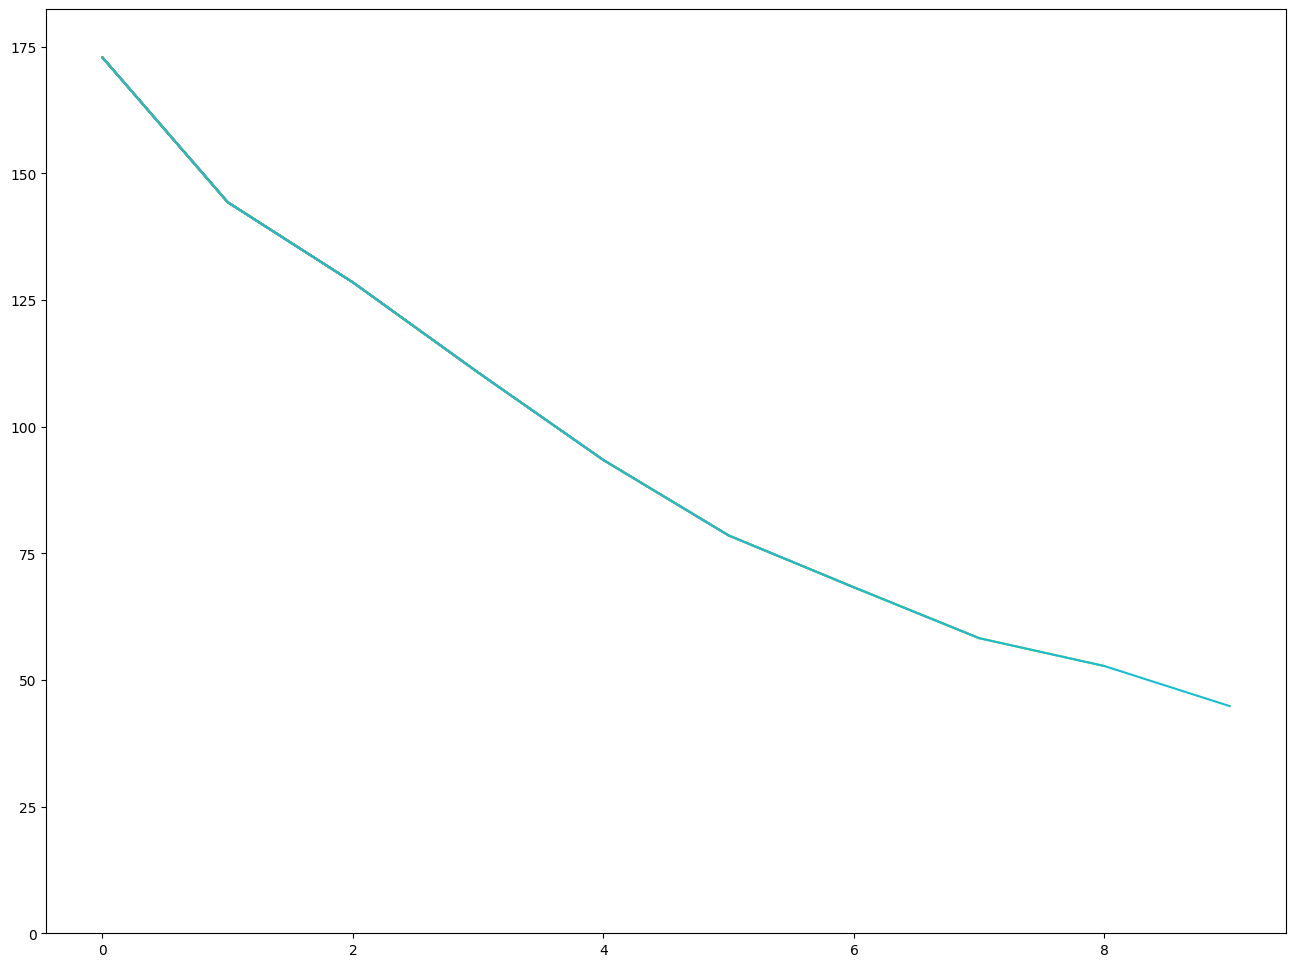

In [58]:
all_training_loss=[]
for epoch in range(num_epochs):
    tr_epoch_loss = 0
    model.train()
    for batch in dataloader:
        # Pad each sequence to the maximum length in the batch
        batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
        batch = batch.to(model.device)
        outputs = model(input_ids=batch, labels=batch)
        
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        tr_epoch_loss += loss.item()
        optimizer.step()
    
    all_training_loss.append(tr_epoch_loss)
    plt.plot(all_training_loss)
    plt.ylim(bottom=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # Save the model after each epoch
    torch.save(model.state_dict(), f'gpt2_finetuned_epoch_{epoch}.pt')

In [63]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the fine-tuned GPT-2 model and tokenizer
# Load the model checkpoint
model_path = "gpt2_finetuned_epoch_9.pt"
model_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Create a new model and load the state dict
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(model_state_dict)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Generate new quotes
prompt = "Life is a journey"
input_ids = tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt')
output = model.generate(input_ids=input_ids, max_length=20, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True)
generated_quotes = [tokenizer.decode(seq, clean_up_tokenization_spaces=True) for seq in output]

# Print the generated quotes
print(generated_quotes)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["Life is a journey. It's a time of true love, of discovery, and of hard work"]
